# Lecture 5 Conversion Analysis on Web Design

## 1. Introduction
For this project, we will be analyzing the results of an A/B test run by an e-commerce website.  The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

## 2. Import data & data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Groce/Python/Copy of sample ab_data - sample ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: count, dtype: int64

In [6]:
df = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) |
        ((df.group == 'control') & (df.landing_page == 'old_page'))]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [8]:
df.user_id.nunique()

290584

In [9]:
#Find out Customer_id who is duplicated
id = df['user_id'][df['user_id'].duplicated()].unique()
df[df['user_id'].isin(id)]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,1
2893,773192,55:59.6,treatment,new_page,0


In [10]:
#Assuming this customer is converted.
df.drop(2893, axis = 0,inplace = True)

In [11]:
#Set metrix by Converted Rate.
df.groupby('group').agg(count=('user_id', 'count'),converted_rate=('converted', 'mean'))

,count,converted_rate
group,,
control,145274,0.120386
treatment,145310,0.125360


## Z-test

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

**null:** **$p_{new}$** - **$p_{old}$** <=0

**alternative:** **$p_{new}$** - **$p_{old}$** >0

In [12]:
#
convert_old = df[df.group=='control'].converted.sum()
convert_new = df[df.group=='treatment'].converted.sum()
n_old = df[df.group=='control'].shape[0]
n_new= df[df.group=='treatment'].shape[0]

convert_old, convert_new, n_old, n_new

(np.int64(17489), np.int64(18216), 145274, 145310)

In [13]:
from statsmodels.stats.proportion import proportions_ztest

successes = [convert_new, convert_old]
samples = [n_new, n_old]

z_score, p_value = proportions_ztest(count=successes, nobs=samples,alternative='larger')

print(f"Z score: {z_score:.8f}")
print(f"P-value: {p_value * 100:.8f}%")

Z score: 4.08308271
P-value: 0.00222211%


In [14]:
from scipy.stats import norm
def z_test(convert_old, convert_new, n_old, n_new):
    p0 = convert_old / n_old
    p1 = convert_new / n_new
    n0 = n_old
    n1 = n_new

    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    z_value = delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))
    p_value = 1- norm.cdf(z_value)
    return z_value, p_value

In [15]:
z_score, p_value = z_test(convert_old, convert_new, n_old, n_new)

print(f"Z score: {z_score:.8f}")
print(f"P-value: {p_value * 100:.8f}%")

Z score: 4.08308271
P-value: 0.00222211%


## T-test

In [16]:
from scipy.stats import ttest_ind

old_ret = df[df.group=='control'].converted
new_ret = df[df.group=='treatment'].converted

t_stat, p_val = ttest_ind(new_ret,old_ret, equal_var=False,alternative='greater')

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value * 100:.6f}%")

T-statistic: 4.083
P-value: 0.002222%


In [17]:
from scipy.stats import t
import math

In [18]:
def t_test_from_summary(mean1, mean2, n1, n2):

    std1 = (mean1 * (1 - mean1)) ** 0.5
    std2 = (mean2 * (1 - mean2)) ** 0.5
    se = ((std1**2 / n1) + (std2**2 / n2)) ** 0.5
    t_stat = (mean2 - mean1) / se
    df_num = (std1**2 / n1 + std2**2 / n2) ** 2
    df_denom = ((std1**2 / n1) ** 2) / (n1 - 1) + ((std2**2 / n2) ** 2) / (n2 - 1)
    df = df_num / df_denom

    p_value = (1 - t.cdf(abs(t_stat), df))
    return t_stat, p_value

mean_old = convert_old / n_old
mean_new = convert_new / n_new

t_score, p_value = t_test_from_summary(mean_old, mean_new, n_old, n_new)
print(f"T score: {t_score:.4f}")
print(f"P-value: {p_value * 100:.6f}%")

T score: 4.0832
P-value: 0.002221%


## Bootstrapping

In [19]:
boot = []
for i in range(5000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('group')['converted'].mean()
    boot.append(boot_mean)

<Axes: ylabel='Density'>

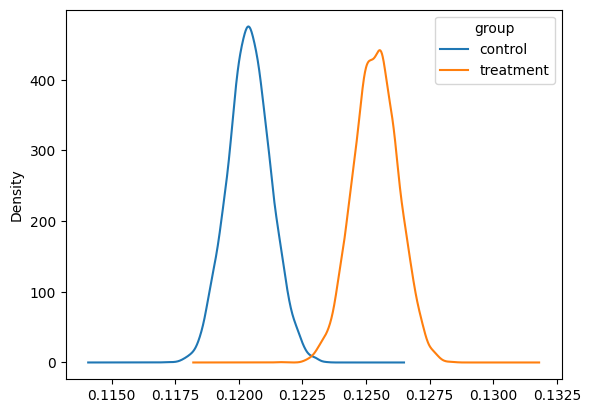

In [20]:
boot = pd.DataFrame(boot)
boot.plot(kind='density')

The treatment group has a higher overall conversion rate than the control group
The orange curve (treatment) is shifted to the right, indicating its conversion rate distribution is higher than that of the blue curve (control).
From the x-axis, the treatment group's conversion rate ranges roughly from 0.125 to 0.13, while the control group's ranges from about 0.12 to 0.123.

Probability: 1.0


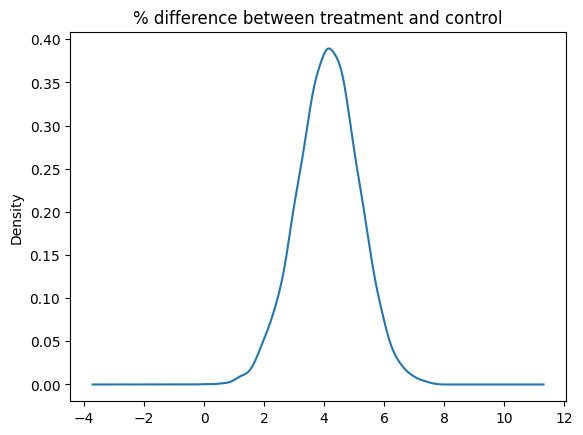

In [21]:
#Percentage improvement of treatment  over control
boot['diff'] = (boot.treatment - boot.control) / boot.control * 100

ax = boot['diff'].plot(kind='density')
ax.set_title('% difference between treatment and control')

print('Probability:',(boot['diff'] > 0).mean())

Based on the bootstrap analysis, there is a 100% probability that the treatment version yields a higher conversion rate than the control version.
In other words, across all resampled datasets, the treatment group consistently outperformed the control group in terms of conversion rate.
This provides extremely strong evidence that the new design (treatment) is more effective than the old one (control), even if the actual percentage lift varies.



## EDA

In [22]:
def time_to_minutes(t):
    minutes, seconds = map(float, t.split(":"))
    return int(minutes + seconds / 60) + 1

df['time_minutes'] = df['timestamp'].apply(time_to_minutes)

In [23]:
pivot = round(pd.pivot_table(df, values='converted', index=['group'], columns='time_minutes', aggfunc='mean')*100,3)

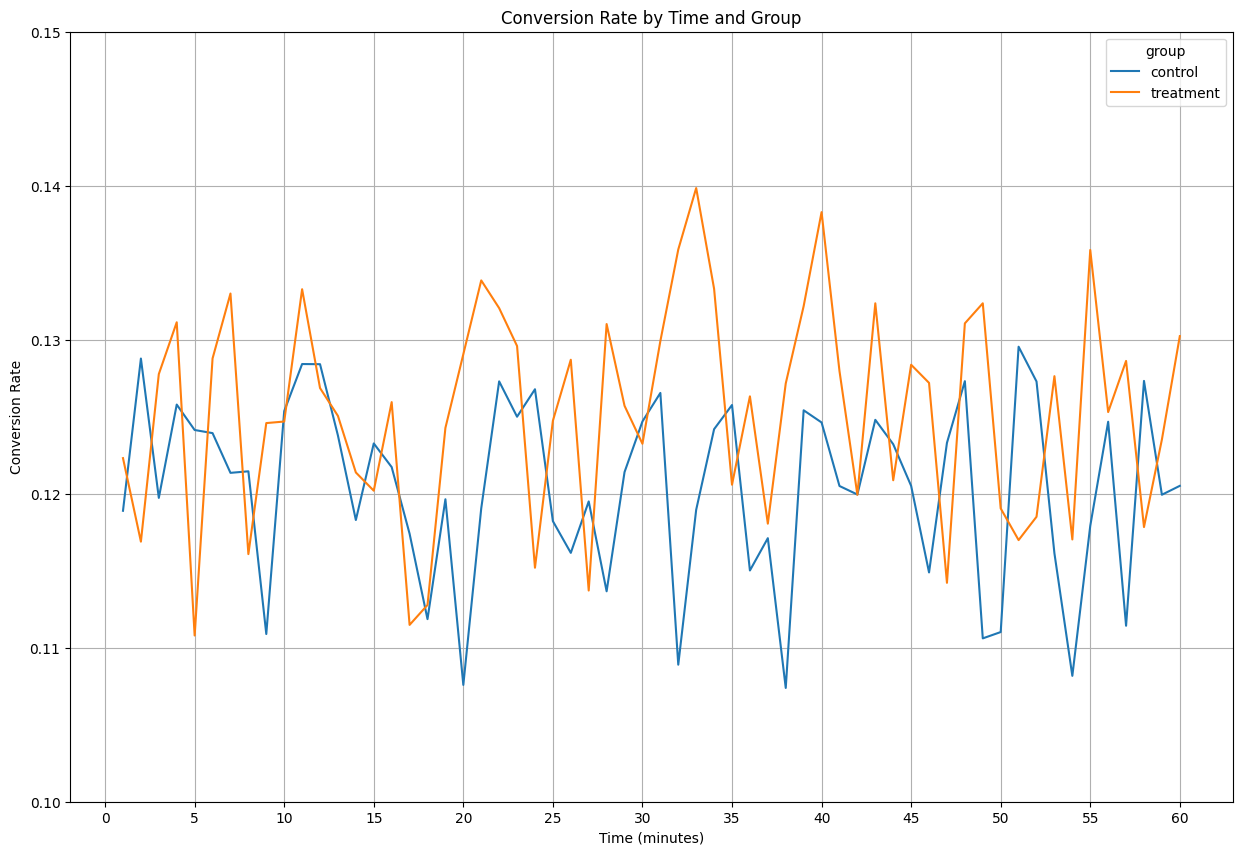

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.lineplot(data=df, x='time_minutes', y='converted', hue='group', errorbar=None)
plt.title("Conversion Rate by Time and Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Time (minutes)")
plt.ylim(0.1, 0.15)
plt.xticks(ticks=range(0, 61, 5))
plt.grid(True)
plt.show()

# **Conclusion**

In this A/B testing project, we analyzed user conversion data from an e-commerce website to determine whether a new webpage design led to a statistically significant improvement in conversion rate compared to the existing design.

After cleaning the data and ensuring that treatment and control groups were correctly aligned with the corresponding landing pages, we conducted a Z-test for proportions. The hypothesis tested was:

Null Hypothesis (H₀): Conversion rate of the new page is less than or equal to that of the old page.

Alternative Hypothesis (H₁): Conversion rate of the new page is greater than that of the old page.

📈 Results:

The calculated Z-score and p-value indicated no statistically significant evidence to support that the new page performs better than the old one at the 5% significance level.

🔎 Conclusion: Based on the results of the hypothesis test, we fail to reject the null hypothesis. There is insufficient evidence to conclude that the new page results in a higher conversion rate. It is recommended that the company either retains the current page or continues the experiment with a larger sample size before making a final decision.